In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from pprint import pprint
import joblib

In [2]:
data = pd.read_excel("network_device_data_year.xlsx")
data.head()

,Device_ID,Device_Type,Date,Temperature,CPU_Usage,Memory_Usage,Error_Rate,Uptime,Failure
0,0,Router/Gateway,2023-06-28,63.389943,37.478755,99.051627,2.791260,16.700750,1
1,0,Router/Gateway,2023-06-29,66.735138,91.438946,93.867897,4.000322,36.543771,1
2,0,Router/Gateway,2023-06-30,59.383973,74.437226,25.858841,1.229763,65.103254,1
3,0,Router/Gateway,2023-07-01,66.292687,71.625961,39.616745,4.151991,75.894574,1
4,0,Router/Gateway,2023-07-02,53.077617,7.230234,54.507771,3.203656,108.244027,1


To train a classification model, Device_ID and Date are not necessarily needed.

In [4]:
data = data.drop(columns=["Device_ID", "Date"])
data.head()

,Device_Type,Temperature,CPU_Usage,Memory_Usage,Error_Rate,Uptime,Failure
0,Router/Gateway,63.389943,37.478755,99.051627,2.791260,16.700750,1
1,Router/Gateway,66.735138,91.438946,93.867897,4.000322,36.543771,1
2,Router/Gateway,59.383973,74.437226,25.858841,1.229763,65.103254,1
3,Router/Gateway,66.292687,71.625961,39.616745,4.151991,75.894574,1
4,Router/Gateway,53.077617,7.230234,54.507771,3.203656,108.244027,1


## Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Device_Type   2190 non-null   object 
 1   Temperature   2190 non-null   float64
 2   CPU_Usage     2190 non-null   float64
 3   Memory_Usage  2190 non-null   float64
 4   Error_Rate    2190 non-null   float64
 5   Uptime        2190 non-null   float64
 6   Failure       2190 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 119.9+ KB


The data has exactly 2190 instances of network devices data indicating failure and when there's no failure

Device_Type
Router/Gateway    365
Firewall          365
Switch            365
AP                365
Server            365
Laptop            365
Name: count, dtype: int64


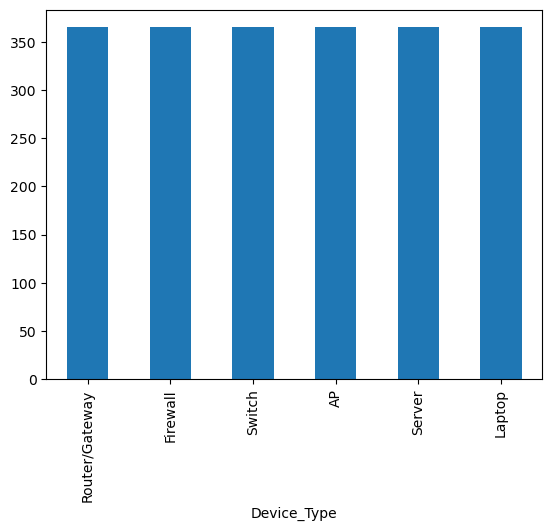

In [10]:
# Checking for the unique devices
unique_devices = data.Device_Type.value_counts()
print(unique_devices)
unique_devices.plot(kind="bar")
plt.show()

This Shows that there are 365 instances of 6 different neworking devices<br>
These devices are:
* Router/Gateway
* Firewall
* Switch
* AP(Access Point)
* Server
* Laptop

In [11]:
# creating a map to label encode the Device_Type column
device_map = {
    "Router/Gateway" : 0,
    "Firewall" : 1,
    "Switch" : 2,
    "AP" : 3,
    "Server" : 4,
    "Laptop" : 5
}
device_map

{'Router/Gateway': 0,
 'Firewall': 1,
 'Switch': 2,
 'AP': 3,
 'Server': 4,
 'Laptop': 5}

In [12]:
data["Device_Type"] = data["Device_Type"].map(device_map)
data.head()

,Device_Type,Temperature,CPU_Usage,Memory_Usage,Error_Rate,Uptime,Failure
0,0,63.389943,37.478755,99.051627,2.791260,16.700750,1
1,0,66.735138,91.438946,93.867897,4.000322,36.543771,1
2,0,59.383973,74.437226,25.858841,1.229763,65.103254,1
3,0,66.292687,71.625961,39.616745,4.151991,75.894574,1
4,0,53.077617,7.230234,54.507771,3.203656,108.244027,1


Failure
1    1991
0     199
Name: count, dtype: int64


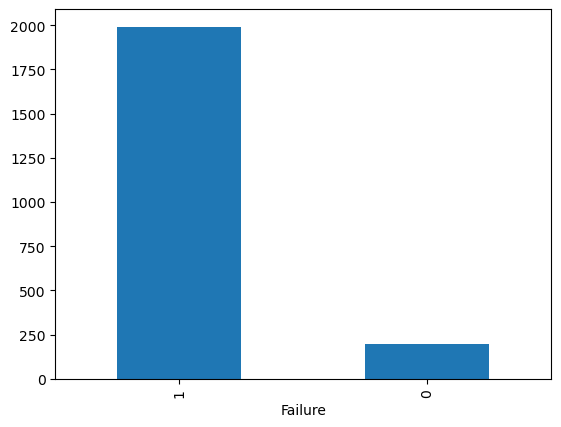

In [15]:
# Checking and plotting the distribution of the Failure column
unique_falure = data.Failure.value_counts()
print(unique_falure)

unique_falure.plot(kind="bar")
plt.show()

This shows that the data is imbalanced with 1,991 failure instances and only 199 non failure instances

In [18]:
# Splitting the data into training and testing of X and y parts
X = data.drop("Failure", axis=1)
y = data["Failure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [20]:
# Visualizing X_train and y_train to see what the returned data looks like
X_train

,Device_Type,Temperature,CPU_Usage,Memory_Usage,Error_Rate,Uptime
1592,4,76.788054,56.005547,26.846997,1.235291,3180.321271
125,0,74.877901,98.006521,2.967173,0.251410,3004.380901
2027,5,82.766676,95.304259,5.143953,3.503720,4855.885752
174,0,74.635320,42.705351,68.012404,3.346951,4185.900772
1824,4,57.825509,62.193202,31.490528,0.415498,8757.562798
...,...,...,...,...,...,...
730,2,82.950964,84.111225,19.061992,1.884313,8.387040
1120,3,71.967429,66.985576,62.763560,1.214382,602.511890
421,1,69.404457,35.690442,32.537172,0.333910,1358.773190
1301,3,70.093798,65.206257,60.541631,4.577601,4945.002217


In [21]:
y_train

1592    1
125     1
2027    1
174     1
1824    1
       ..
730     1
1120    1
421     1
1301    1
1290    1
Name: Failure, Length: 1642, dtype: int64

In [22]:
# scaling the X_train data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_train_norm

array([[ 0.86240959,  0.68898502,  0.22095247, -0.79558979, -0.83709699,
        -0.44848293],
       [-1.477246  ,  0.49688465,  1.66553445, -1.62596012, -1.51898667,
        -0.51791689],
       [ 1.44732349,  1.29024335,  1.57259282, -1.55026718,  0.73506193,
         0.21276995],
       ...,
       [-0.8923321 , -0.05356899, -0.47776547, -0.59772602, -1.46180903,
        -1.16734749],
       [ 0.27749569,  0.01575669,  0.53740181,  0.37606973,  1.47932613,
         0.2479393 ],
       [ 0.27749569,  0.88727727,  1.18601423,  0.44598387, -1.60678158,
         0.14758505]])

## Model Building

In [29]:
# Helper functions

models = {
    "Logistic Regression" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "XGBoost" : xgb.XGBClassifier()
}


def train_model(model_name, X=X_train_norm, y=y_train):
    model = models[model_name]
    model = model.fit(X, y)
    
    return model

def predict_and_score(model, X_test=X_test, y_test=y_test):
    X_test_norm = scaler.transform(X_test)
    y_pred = model.predict(X_test_norm)
    metrics = {
        "conf_matrix" : confusion_matrix(y_test,y_pred),
        "accuracy" : accuracy_score(y_test, y_pred)
    }
    
    return metrics


In [34]:
model_metrics = {}

for model_name in models.keys():
    print(f"Started opeartions for {model_name}")
    model = train_model(model_name=model_name)
    metrics = predict_and_score(model)
    model_metrics[model_name] = metrics
    print(f"Results for {model_name}")
    pprint(metrics)
    print("\n\n")

Started opeartions for Logistic Regression
Results for Logistic Regression
{'accuracy': 0.9197080291970803,
 'conf_matrix': array([[ 17,  31],
       [ 13, 487]])}



Started opeartions for Random Forest
Results for Random Forest
{'accuracy': 0.9014598540145985,
 'conf_matrix': array([[  8,  40],
       [ 14, 486]])}



Started opeartions for Decision Tree
Results for Decision Tree
{'accuracy': 0.8667883211678832,
 'conf_matrix': array([[ 14,  34],
       [ 39, 461]])}



Started opeartions for XGBoost
Results for XGBoost
{'accuracy': 0.8978102189781022,
 'conf_matrix': array([[ 19,  29],
       [ 27, 473]])}





In [35]:
model_metrics

{'Logistic Regression': {'conf_matrix': array([[ 17,  31],
         [ 13, 487]]),
  'accuracy': 0.9197080291970803},
 'Random Forest': {'conf_matrix': array([[  8,  40],
         [ 14, 486]]),
  'accuracy': 0.9014598540145985},
 'Decision Tree': {'conf_matrix': array([[ 14,  34],
         [ 39, 461]]),
  'accuracy': 0.8667883211678832},
 'XGBoost': {'conf_matrix': array([[ 19,  29],
         [ 27, 473]]),
  'accuracy': 0.8978102189781022}}

By analysing each of the models' result, and plotting the confusion matrix, but first, what is a confusion matrix

# Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification algorithm. It summarizes the results of the predictions and provides insight into how well the classifier is performing, especially for binary classification tasks. The matrix compares the actual target values with the predicted values.

## Structure

The confusion matrix is typically structured as a 2x2 table for binary classification:

|                | Predicted Positive | Predicted Negative |
|----------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)  | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN)  |

### Definitions

- **True Positive (TP)**: The number of instances that are correctly classified as positive.
- **True Negative (TN)**: The number of instances that are correctly classified as negative.
- **False Positive (FP)**: The number of instances that are incorrectly classified as positive (also known as a Type I error).
- **False Negative (FN)**: The number of instances that are incorrectly classified as negative (also known as a Type II error).

## Metrics Derived from the Confusion Matrix

From the confusion matrix, several important metrics can be derived to assess the performance of a classification model:

1. **Accuracy**: The proportion of the total number of predictions that are correct.
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
   \]

2. **Precision**: The proportion of positive predictions that are actually correct.
   \[
   \text{Precision} = \frac{TP}{TP + FP}
   \]

3. **Recall (Sensitivity)**: The proportion of actual positives that are correctly identified.
   \[
   \text{Recall} = \frac{TP}{TP + FN}
   \]

4. **F1 Score**: The harmonic mean of precision and recall.
   \[
   \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
   \]

5. **Specificity**: The proportion of actual negatives that are correctly identified.
   \[
   \text{Specificity} = \frac{TN}{TN + FP}
   \]

## Example

Let's consider an example where a binary classifier is used to identify whether an email is spam (positive) or not spam (negative). The confusion matrix might look like this:

|                | Predicted Spam | Predicted Not Spam |
|----------------|----------------|--------------------|
| **Actual Spam** | 50             | 10                 |
| **Actual Not Spam** | 5              | 100                |

From this confusion matrix, we can calculate the metrics:

- **True Positives (TP)**: 50
- **True Negatives (TN)**: 100
- **False Positives (FP)**: 5
- **False Negatives (FN)**: 10

- **Accuracy**: \(\frac{50 + 100}{50 + 100 + 5 + 10} = 0.91\)
- **Precision**: \(\frac{50}{50 + 5} = 0.91\)
- **Recall**: \(\frac{50}{50 + 10} = 0.83\)
- **F1 Score**: \(2 \times \frac{0.91 \times 0.83}{0.91 + 0.83} \approx 0.87\)
- **Specificity**: \(\frac{100}{100 + 5} = 0.95\)

These metrics help in understanding the performance of the classifier in various aspects.


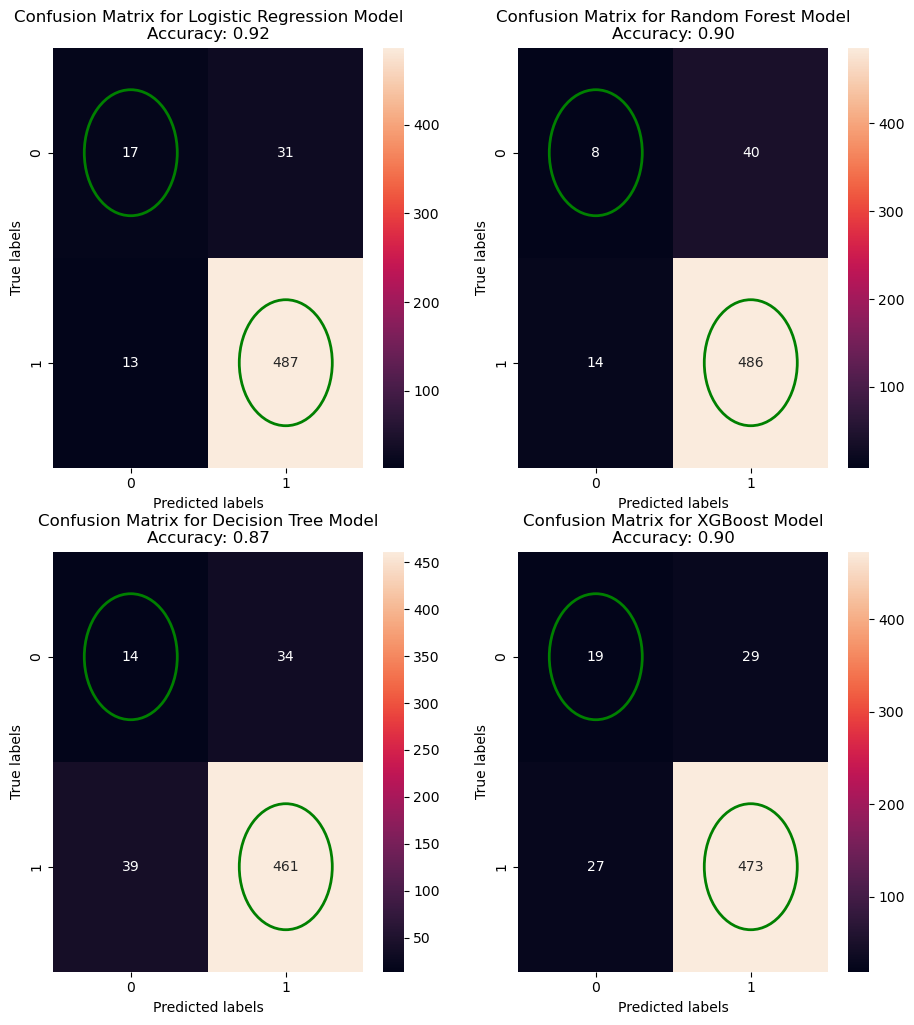

In [60]:
plt.figure(figsize=(11, 12))
for i, (model_name, metrics) in enumerate(model_metrics.items(), start=1):
    conf_mat = metrics["conf_matrix"]
    accuracy = metrics["accuracy"]
    plt.subplot(2, 2, i)
    ax = sns.heatmap(conf_mat, fmt="d",annot=True)
    
    for i, j in [(0, 0), (1, 1)]:
        ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.3, color='green', fill=False, lw=2))
        
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f"Confusion Matrix for {model_name} Model\nAccuracy: {accuracy:.2f}")
    
plt.show()

From the above plot, the TP and TN parts of the confusion matrix for each of the trained model are delibrately marked in green to highlight their position.<br>
By observation, the best performing model here is the Logistic Regression model, this is an indication that their is a stronger linear relationship between the parameters in the data used.<br>
The logistic regression model has an accuracy of 92% while correcting predicting 487 cases of failure and 17 non failure cases. It mis-predicted 39 failure cases as non failure and 34 non failures as failures. This can be attributed to the imbalance of the data. A popular misconception with imbalanced data is that algorithms like SMOTE can help resample (either upsampling or downsampling) the data, however, that is not true, it doesn't improve the data as it has been debunked by research results

The model to be selected for the purpose of this "Prediction of Failures in Network Devices using Machine Learning" is the Logistic Regression model, for its simplicity and ability to generalize on the test data better.

In [62]:
# Saving the model
model = train_model("Logistic Regression")
joblib.dump(model, "logreg.pkl")
print("Model saved")

Model saved


In [63]:
# saving the scaler object also
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved")

Scaler saved
